# Assignment 5 - Fraud Detection
## Oscar Engelbrektson
## Prof. Sterne, CS156, Fall 2019

Given data containing personal transactions of Prof. Sterne over a period of several years, the purpose of this assignment is to use kernel density estimation to generate one month worth of fake transaction data. The approach will be the following:

Fit densities to each of the following quanitities:
1. the number of transactions that occur in a single month.
2. the day in the month that a transaction will occur on.
3. transaction size.

Given the distributions over each of these quantities estimated via KDE, generate one month's worth of fake data by:
1. Draw a sample N, from the distribtion over the number of transactions that occur in a single month. N will be the number of transactions that occur in the fake month.
2. Draw N samples from the distribution over the day in the month that a transaction will occur on. These samples will determine on which days in the fake month the fake transactions take place.
3. For each of the N fake transaction, draw a sample from the distribution over transaction size. This will be the size of the fake transaction.


We have now generated one month worth of fake transaction data.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

import scipy.stats as sts
from sklearn.neighbors.kde import KernelDensity
from sklearn.mixture import GaussianMixture
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV

In [42]:
#Load the data
data = pd.read_csv("/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/anonymized.csv")
data.head()

,Date,Amount
0,25May2016,54241.35
1,29May2017,54008.83
2,30Jun2017,54008.82
3,05Jan2017,52704.37
4,23Feb2017,52704.36


# Pre-processing
The data already has the transaction size under "Amount", we need to extract the day of the month and the month from each date as disctinct features. We will fit KDEs to each of these features in 1. and 2. .

The data set contains multiple years of data. Consequently, to model the number of transactions that occur in a month, we must take care not to throw all transactions that occured in the month of January into the same bucket–we would be counting 4 months, january each year, worth of data. Consequently, even though we won't use the year for any sampling, it still matters in so far as it allows us to distinguish different months, e.g. Jan 2016 =/= Jan 2017.

In [44]:
data['Day'] = np.array([x[0:2] for x in data.Date.values])

#Extract the month, convert string to number of month using dict mapping
data['Month'] = np.array([x[2:5] for x in data.Date.values])
month_dict = {v: k for k,v in enumerate(calendar.month_abbr)}
data["Month"] = [month_dict[data["Month"][i]] for i in range(len(data["Month"]))]

#Extract the year, the last 4 characters of the Date
data['Year'] = np.array([x[5:10] for x in data.Date.values])

#We drop "Date" as all the information contained therewithin is now extracted
data = data.drop(columns=["Date"], axis=1)

In [161]:
data.head()

,Amount,Day,Month,Year
0,54241.35,25,5,2016
1,54008.83,29,5,2017
2,54008.82,30,6,2017
3,52704.37,05,1,2017
4,52704.36,23,2,2017


## Defining a KDE selection function

Given a choice of kernel, a kernel density estimation model takes one hyperparameter–the bandwidth of each kernel. As we use a gaussian kernel, the bandwidth denotes the standard deviation of the gaussian centered on each datapoint. Higher standard deviation means that each gaussian will contribute broader, less concentrated probability mass to the KDE; in the extreme where bandwidth approaches 0, the KDE will have a peak at every datapoint with not probability mass inbetween. Therefore, the bandwidth selected determines the smoothness of the KDE and is highly consequential to the samples generated therefrom.

We use k-fold cross validation to select the bandwidth for each KDE. The mean log-likelihood of the validation set across the k folds is computed for each bandwidth, and the highest scoring bandwidth is selected.
I set the linspace range, i.e. the bandwidth's tested in the cross-validation procedures, to be proportional to the order of magnitude of the data. If the optimal value lies on the edge of the linspace interval, I extend the interval until the selected bandwidth is no longer the most extreme bandwidth tested.

In [460]:
def fit_kde(data, bw_params, cv=5):
    '''
    Takes a dataset of observations of a variable and a list of band widths. 
    Using k-fold CV for the KDE, the mean log-likelihood of the validation set across the k folds
    is computed for each bandwidth. 
    Returns a KernelDensity object trained on all the data using the maximum likelihood bandwidth.
    '''
    data = sorted(data)
    
    #Scoring is log-likelihood of the data. We select bandwidth to maximise the log-likelihood.
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bw_params},
                    cv=cv, iid=True) # 5-fold cross-validation
    grid.fit(data)
    
    #Print the maximum likelihood bandwidth and the corresponding likelihood
    print("The best bandwidth is %s"
      % (grid.best_params_))
    
    #Fit a kde using the cv bandwidth
    kde = KernelDensity(kernel='gaussian', bandwidth=grid.best_params_['bandwidth']).fit(data)
    
    #return the fitted kde
    return kde

def plot_kde(data, kde, title, xlabel, bins="auto"):
    '''
    Takes a dataset of observations of a variable and a KernelDensity object trained on it.
    Returns a histogram of the dataset with the KernelDensity estimate over laid.
    '''
    plt.figure(figsize=(12,8))

    #Plot the kde over the support of the training data
    x_plot = np.linspace(min(data)-1, max(data)+1, 500)
    log_dens = kde.score_samples(x_plot.reshape(-1,1))
    plt.plot(x_plot, np.exp(log_dens), '-', label="kernel")
    
    #Plot a histogram of the data
    plt.hist(data, bins=bins, density=True, label="data")
    plt.ylabel("Density")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend(loc=0)
    plt.show()

## 1. Fitting a KDE to the number of transactions that occur in a single month

In [59]:
monthly_transactions = data.groupby(['Month', "Year"]).count()["Day"]
month_kde = fit_kde(monthly_transactions[:, None], np.linspace(1, 50, 100))

The best bandwidth is {'bandwidth': 11.88888888888889}


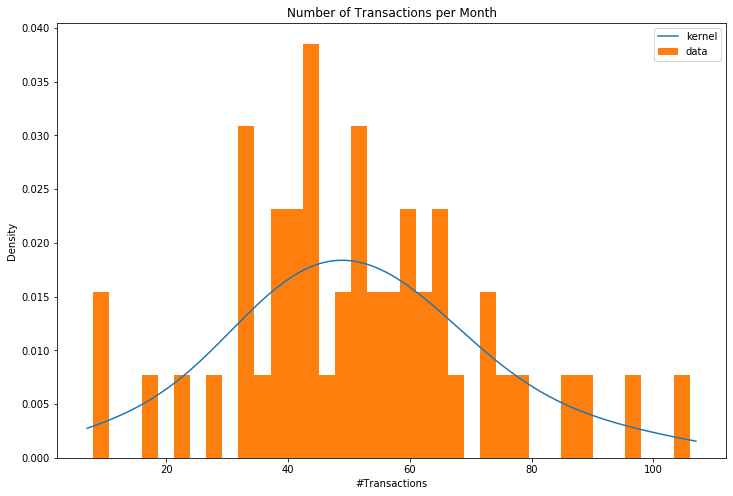

In [461]:
plot_kde(monthly_transactions, month_kde, title="Number of Transactions per Month", 
         xlabel="#Transactions", bins=len(np.unique(monthly_transactions)))

## 2. Fitting a KDE to the day in the month that a transaction will occur on.

In [450]:
day_of_month = data["Day"].astype(int)
#Number of observations of day of month 
print("Unique days in a month:",len(day_of_month.unique()), 
      "\nNumber of observations of day of month:",len(day_of_month))

Unique days in a month: 31 
Number of observations of day of month: 2518


Day of month is a discrete variable with 31 possible values. At the same time, there are over 2500 observations split across these 31 values, as shown by the histogram above. Consequently, having a validations set size around 100 seems reasonable given that there are only 31 possible values, i.e. performing 20-fold cross validation we get a validation set more than 3x the size of possible values, any more than that seems excessive.

In [143]:
#Fitting a the KDE
day_kde = fit_kde(day_of_month[:, None], np.linspace(0.01, 10, 100), cv=20)

The best bandwidth is {'bandwidth': 3.6427272727272726}


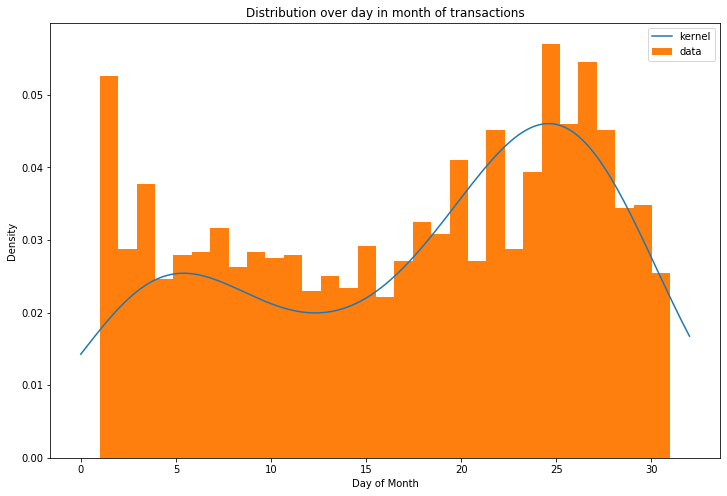

In [462]:
plot_kde(day_of_month, day_kde, title="Distribution over day in month of transactions", 
         xlabel="Day of Month", bins=31)

## 3. Fitting a KDE to the transaction size

In [125]:
transaction_size = data["Amount"].astype(int)

amount_kde = fit_kde(transaction_size[:, None], np.linspace(100, 10000, 100))

The best bandwidth is {'bandwidth': 7900.0}


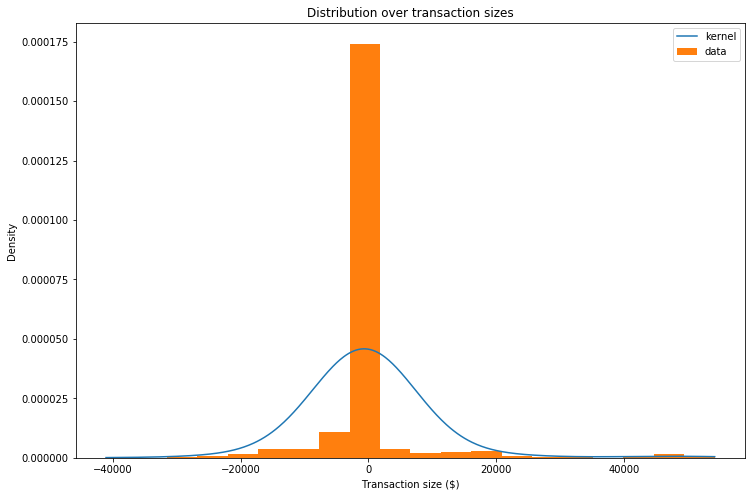

In [463]:
plot_kde(transaction_size, amount_kde, title="Distribution over transaction sizes", 
         xlabel="Transaction size ($)", bins=20)

# Generating a month worth of fake data

#### 1. Draw a sample from the distributon over transactions per month. 

N. The number of transactions is a discrete variable with support on all non-negative integers. Consequently, we must round each sample to the nearest integer – there cannot be 100.12312 transactions in a month! 

#### 2. Draw N samples from the distrbution over transaction per day in a month. 
Day of the month is a discrete variable with support on integers in the range 0 to 31. However, by fitting a gaussian to each datum, we have created (1) a CONTINOUS model with (2) positive probability mass outside the support of the variable. For example, by fitting a gaussian with bandwidth 4 to an observation on day 0, 50% of the probability mass it contributes to the model will be less than 0. Yet, if you tell the IRS a transaction took place on the -2nd day of the month you won't fool anyone. Consequently, to make samples drawn from this KDE plausible, we must do some fixing:

    1. If a sample is smaller than 0 or greater than 31, reject it and draw another. Repeat until N samples have been accepted.
    2. Once all samples are in the supported range, round to the nearest integer – there is no 12.12321th day.
#### 3. Get size of each of the N transactions by drawing from the distribution over transaction sizes.
Similarly to the two steps above, we must correct for the continouty of the KDE model. Transactions are recorded down to two decimal point precision, i.e. the nearest cent. We round our samples to reflect this.

In [264]:
def fake_month():
    #Sample the number of transactions there will be in the month
    N = int(np.round(month_kde.sample()))
    
    #Sample the day that each transaction occurs
    transaction_day = []
    while len(transaction_day) < N:
        proposal = int(np.round(day_kde.sample()))
        if proposal >= 0 and proposal <= 31:
            transaction_day.append(proposal)
                
    #Sample the size of each transaction, round to 2decimal points
    transaction_size = []
    for _ in range(N):
        transaction_size.append(float(np.round(amount_kde.sample(), 2)))
    
    #Save as Dataframe
    fake_month = pd.DataFrame()
    fake_month["Day"] = sorted(transaction_day)
    fake_month["Amount"] = transaction_size
    
    return fake_month

In [265]:
simulated_month = fake_month()
simulated_month

,Day,Amount
0,0,4070.59
1,1,-3236.56
2,1,12810.59
3,1,-16512.94
4,1,-11939.33
5,1,5431.98
6,2,-4964.77
7,2,12831.82
8,2,-4891.86
9,3,-13198.93


## Why this probably isn't a great approach to bank fraud

1. We are assuming the number of transactions in a month, the day of the month a transaction takes place and the size of the transaction are all independent. This is unlikely to be true. Humans are creatures of habit. For example, are likely recurrent patterns in the data. Like getting salaried the same amount the same day of the month each month, or paying recurring bills, like electricity or credit card, the same day of the month every month. We fail to capture any such conditionality properties with our KDEs.

2. The model does not distinguish between ingoing and outgoing transactions. In reality, these distribution may be noticably different. For example, in reality there may never be ingoing transactions on a Sunday. But in our model there is positive probability for that event.

1. The model assumes that transactions are drawn from a continous distribution over the support of the entire amount history. This isn't really realistic in the sense that there are large regions of the support, the range spanned by the minimum transaction and the largest transaction, that have never been explored. For example, in the real world, no transactions ever take place on a Sunday. In the model, we assume a continous distribution over the days of the month, yielding postive probalities of sampling sundays. We saw this in action, when we had a positive probability of sampling negative days of the month. In that case, we corrected for it. But we have not made such corrections elsewhere, and there likely are similar instances where implausible values are being generated because of this assumption.

Any of these flaws could be picked up by a forensic accountant, and all these together would make it exceedingly unlikely that the data was not fabricated.

# (Optional) How well does the data follow Benford’s law?
A set of numbers is said to satisfy Benford's law if the leading digit d (d ∈ {1, ..., 9}) occurs with probability P(d) = Log_10(1 + 1/d) (Wikipedia, n.d.).

Let's examine how well that hold's for our simulated observations.

In [361]:
def benfords_law(d):
    return np.log10(1+1/d)

In [349]:
#Predicted probability of each of the first 9 digits
benfords_prediction = [benfords_law(x) for x in range(1,10)]

#Normalize benfords over the first 9 digits
normalized_benfords = [x/np.sum(benfords_prediction) for x in benfords_prediction]

#Compute the cdf of the normalized benfords distribution
cummulative_benfords = [np.sum(normalized_benfords[:i]) for i in range(1, len(normalized_benfords)+1)]

def sample_benford():
    '''
    Sample from the normalized benford distribution
    by drawing sample from the normal uniform distribution
    and projecting it onto the corresponding index in the cdf of benfords
    '''
    
    rand = np.random.rand()
    
    sample = 1
    while rand > cummulative_benfords[sample-1]:
        sample += 1
        
    return sample

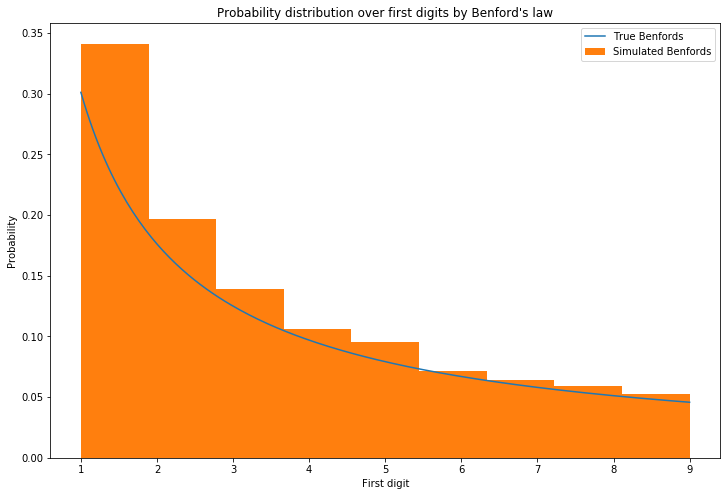

In [446]:
#Checking the simulation works and visualizing Benfords Law
plt.figure(figsize=(12,8))

#True benfords
x = np.linspace(1, 9, 200)
true_benfords = plt.plot(x, benfords_law(x), label="True Benfords")

#Simulated Benfords
simulated_benfords = [sample_bedford() for _ in range(20000)]
plt.hist(simulated_benfords, density=True, bins=9, label="Simulated Benfords")

plt.title("Probability distribution over first digits by Benford's law")
plt.xlabel("First digit")
plt.ylabel("Probability")
plt.legend(loc=0)
plt.show()

In [415]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def test_statistic(data):
    '''
    Takes a 1x9 array of propostions of first digits for numbers 1 through 9, 
    data[i] = proportion of time digit i+1 was first.
    Returns root mean square deviation from bedfords law prediction
    '''
    return np.sqrt(np.mean((normalized_benfords-data) ** 2))

## Finding the first digit of our simulated data

In [418]:
def first_digit(x):
    '''
    Finds the first digit of x by iteratively performing
    integer division by 10 until only the first digit remains
    '''
    x = abs(x)
    while x >= 10:
        x = x // 10

    return x

def digit_rate(arr):
    '''
    Takes array of first digits, returns 
    1x9 array with proportion of times each number appears
    data[i] = proportion of time digit i+1 was first.
    '''
    
    #Count occurence of each first digit
    digit_counts = np.zeros(9)
    for x in arr:
        digit_counts[int(x)-1] += 1
    
    #Normalize by total count to get proportion
    normalization = np.sum(digit_counts)
    
    digit_rates = np.array([digit_counts[i]/normalization for i in range(len(digit_counts))])
    return digit_rates

In [407]:
#Get first digit of every observation for day and amount
fd_amount = [first_digit(simulated_month["Amount"].loc[i]) for i in range(len(simulated_month))]
fd_day = [first_digit(simulated_month["Day"].loc[i]) for i in range(len(simulated_month))]

#Make Dataframe with proportion of first digits for day and amount
first_digits = pd.DataFrame()
first_digits["Amount"] = digit_rate(fd_amount)
first_digits["Day"] = digit_rate(fd_day)

In [439]:
sim_amount_statistic = test_statistic(first_digits["Amount"]) 
sim_day_statistic = test_statistic(first_digits["Day"]) 

## Performing hypothesis testing by comparing the test statistic of the simulated data against data sampled from Benford's Distribtion

To estimate the probability that the simulated data follows Benford's law, we draw samples of the same size as the simulated data from Benford's Distribution and compute the test statistic. We repeat this process 10 000 times, thereby generating a distribution over the values of the test statistic under the null hypothesis that the data is sampled from Benford's Law distribution. We can then use this distribution for comparison to compute p-values for the probability that the simulated data follow Benford's Law.

P-values around 0.5 provide support for the null, values closer to 1 or 0 means it is unlikely that the null is true.

In [421]:
test_list= []
N = len(simulated_month)
for _ in range(10000):
    sim = digit_rate([sample_bedford() for _ in range(N)])
    
    test_list.append(test_statistic(sim))

In [440]:
#Computing the p-value by calculating the proportion of times the 
#Test statistic for the simulated data is more lower than that of the data sampled from Benford's Distribution
print("The p-value for the test statistic of the simulated Amount data is %0.3f"
     % np.mean(sim_amount_statistic < test_list))

print("The p-value for the test statistic of the simulated Day data is %0.10f"
     % np.mean(sim_day_statistic < test_list))

The p-value for the test statistic of the simulated Amount data is 0.012
The p-value for the test statistic of the simulated Day data is 0.0000000000


The p-values for both statistics are very small, close to 0. This means it is exceedingly unlikely the data follow Benford's Law. That is, we find sufficient evidence to reject the null hypothesis. We can show this visually by comparing the values of the test statistics of the simulated data to the test statistics of the data sampled from Benford's Distribution. We you can see below, both test statistics are in the far right tails of the distribution.

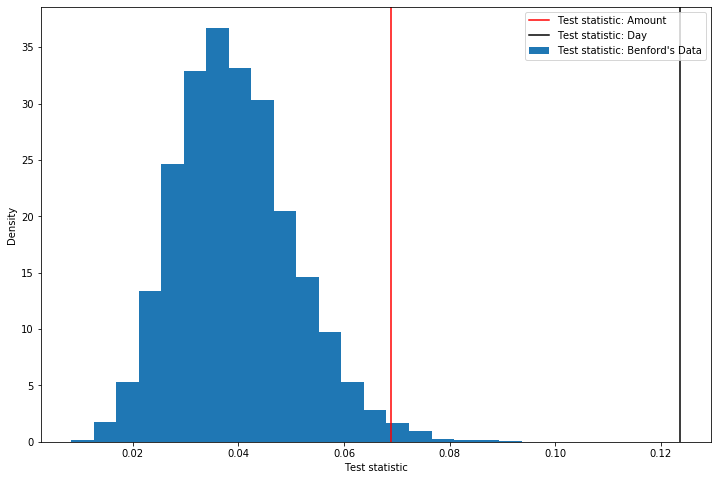

In [442]:
plt.figure(figsize=(12,8))
plt.hist(test_list, bins=20, density=True, label="Test statistic: Benford's Data")
plt.axvline(x=sim_amount_statistic, color="r", label="Test statistic: Amount")
plt.axvline(x=sim_day_statistic, color="black", label="Test statistic: Day")
plt.xlabel("Test statistic")
plt.ylabel("Density")
plt.legend(loc=0)
plt.show()

Resources:
    
Wikipedia. (n.d.). Benford's Law. 
    
    retrieved
    https://en.wikipedia.org/wiki/Benford%27s_law